# 《Scikit-Learn与TensorFlow机器学习实用指南》 第03章 分类

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784")

In [2]:
X, y = mnist["data"],mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

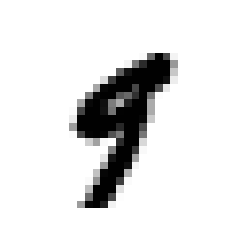

In [24]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd


type(X)
# data = pd.DataFrame(X)

some_digit = X.iloc[[36000]]
# # some_digit_image = some_digit.reshape(28,28)
# type(some_digit)
some_digit_image = some_digit.values.reshape(28,28)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [28]:
# y.iloc[[36000]]
y[36000]

'9'

## 创建训练集和测试集

In [29]:
# 分割训练集和测试集
index = 60000
x_train, x_test, y_train, y_test = X[:index], X[index:], y[:index], y[index:]

In [39]:
# 查看数据规模
x_train.shape, x_test.shape, y_train.count(), y_test.count()

((60000, 784), (10000, 784), 60000, 10000)

In [42]:
# 打乱训练集,保证交叉验证的每一折都是相似
import numpy as np

shuffle_index = np.random.permutation(60000)
x_train, y_train = x_train[shuffle_index], y_train[shuffle_index]

array([37888, 19366, 57987, 44750, 38210])

## 训练一个二分类器

In [82]:
# 确定一个目标，例如，是否是9
x_train_9 = (x_train == '9')
y_train_9 = (y_train == '9')

In [83]:
import pandas as pd
yy = pd.DataFrame(y_train_9)
yy.value_counts()

class
False    54051
True      5949
dtype: int64

In [84]:
## 用随机梯度下降分类器 SGD
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train_9)

SGDClassifier(random_state=42)

In [79]:
sgd_clf.predict(some_digit)

array([False])

In [81]:
sgd_clf.score(x_train,y_train_9)

0.7867333333333333

## 对性能的评估

## 实现交叉验证

In [100]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# 需要设置shuffle，否则报错：ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

# type(x_train)

for train_index ,test_index in skfolds.split(x_train, y_train_9):
    # print(train_index, test_index)
    clone_sgd = clone(sgd_clf)
    x_train_folds = x_train.iloc[train_index]
    y_train_folds = y_train[train_index]

    x_test_folds = x_train.iloc[test_index]
    y_test_folds = y_train[test_index]

    clone_sgd.fit(x_train_folds, y_train_folds)
    y_pred = clone_sgd.predict(x_test_folds)
    n_correct = sum(y_test_folds == y_pred)
    print(n_correct/len(y_pred))

0.88805
0.8835
0.8677


## 使用cross_val_score评估

In [102]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, x_train, y_train_9, cv=3, scoring="accuracy")

array([0.9456 , 0.95195, 0.9509 ])

# 混淆矩阵

In [103]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_9, cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

In [104]:
from sklearn.metrics import confusion_matrix

#           TN              FP
#           预测非9         预测是9
#   实际非9  52715          1336
#   实际是9  1695           4254
#            FN             TP
confusion_matrix(y_train_9, y_train_pred)

array([[52715,  1336],
       [ 1695,  4254]], dtype=int64)

# 准确率与召回率

In [105]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_train_9, y_train_pred)

recall = recall_score(y_train_9, y_train_pred)

precision, recall

(0.7610017889087657, 0.7150781643973777)

In [106]:
from sklearn.metrics import f1_score

f1_score(y_train_9, y_train_pred)

0.737325591472398

In [119]:
y_scores = sgd_clf.decision_function(some_digit)

y_scores

array([-4440.66086996])

In [120]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_9, cv=3, method="decision_function")
y_scores

array([-23009.36445429, -18436.99768895, -15940.48683084, ...,
       -30278.93992241, -28156.99780661,  -6860.27399688])

In [121]:
from sklearn.metrics import precision_recall_curve

precision, recall,thresholds = precision_recall_curve(y_train_9, y_scores)
precision, recall,thresholds

(array([0.10595968, 0.10594375, 0.10594564, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 9.99831905e-01, 9.99831905e-01, ...,
        3.36190956e-04, 1.68095478e-04, 0.00000000e+00]),
 array([-52486.6904895 , -52483.5824911 , -52479.6675275 , ...,
         20225.53507163,  20552.95117091,  21027.68503262]))

In [128]:
precision.shape

(56145,)

# 使用 Matplotlib 画出准确率和召回率

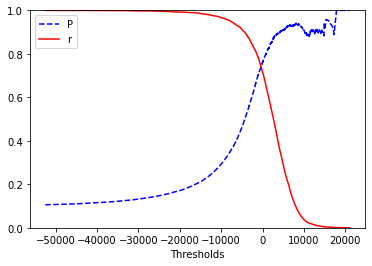

In [147]:
plt.plot(thresholds, precision[:-1], "b--", label="Precision")
plt.plot(thresholds, recall[:-1], "r-", label="Recall")
plt.xlabel("Thresholds")
plt.legend("Precision Recall")
plt.ylim([0, 1])
plt.show()

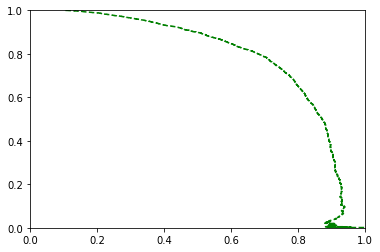

In [146]:
plt.plot(precision, recall, "g--", label="rc")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.show()

In [160]:
y_train_pred_9 = (y_scores > 0)

In [161]:
precision_score(y_train_9, y_train_pred_9)

0.7610017889087657

In [162]:
recall_score(y_train_9, y_train_pred_9)

0.7150781643973777

# ROC 曲线

In [163]:
from sklearn.metrics import roc_curve

fpr, tpr , thresholds = roc_curve(y_train_9, y_scores)

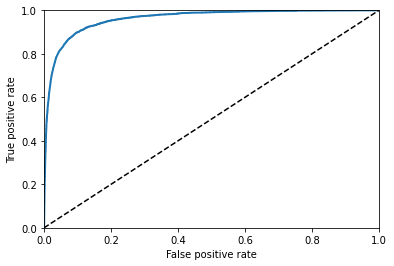

In [171]:
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], "k--")
plt.axis([0, 1, 0, 1])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

In [172]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_9, y_scores)

0.96114559368217

## 当正例很少，或者当你关注假正例多于假反例的时候，优先使用 PR 曲线。其他情况使用 ROC 曲线

In [173]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier()
y_probas_forest  = cross_val_predict(forest_clf, x_train, y_train_9, cv=3, method="predict_proba")